In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.datasets import mnist
from torch.utils.data import TensorDataset
from tqdm import tqdm

import torch.nn as nn
from torch.utils.data import DataLoader

import torch


import pandas as pd
import os
import kagglehub
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import random
# from ultralytics import YOLO

# Download latest version
path = kagglehub.dataset_download("biancaferreira/african-wildlife")

print("Path to dataset files:", path)

Path to dataset files: /Users/amannindra/.cache/kagglehub/datasets/biancaferreira/african-wildlife/versions/1


In [161]:
print(tf.__version__)
print(torch.__version__)

2.12.0
2.1.0+cu118


In [ ]:
buffalo = os.path.join(path, "buffalo")
elephant = os.path.join(path, "elephant")
rhino = os.path.join(path, "rhino")
zebra = os.path.join(path, "zebra")


if os.path.exists(buffalo):
    print("Buffalo dataset found")
else:
    print("Buffalo dataset not found")

if os.path.exists(elephant):
    print("Elephant dataset found")
else:
    print("Elephant dataset not found")

if os.path.exists(zebra)
    print("zebra dataset found")
else:
    print("zebra dataset not found")

if os.path.exists(zebra):
    print("Zebra dataset found")
else:
    print("Zebra dataset not found")

Buffalo dataset found
Elephant dataset found
zebra dataset found
Zebra dataset found


In [163]:
def pre_process_data(animal, num):
    x_center = []
    y_center = []
    width = []
    height = []
    images = []

    animal_files = os.listdir(animal)

    for i in animal_files:
        if i.endswith(".txt"):
            with open(os.path.join(animal, i), "r") as file:
                content = file.read()
                split_content = content.split(" ")
                x_center.append(split_content[1])
                y_center.append(split_content[2])

                if split_content[4].endswith("\n1"):
                    split_content[4] = split_content[4].replace("\n1", "")
                    width.append(split_content[4])
                elif split_content[4].endswith("\n0"):
                    split_content[4] = split_content[4].replace("\n0", "")
                    width.append(split_content[4])
                elif split_content[4].endswith("\n"):
                    split_content[4] = split_content[4].replace("\n", "")
                    width.append(split_content[4])
                elif split_content[4].endswith("\n3"):
                    split_content[4] = split_content[4].replace("\n3", "")
                    width.append(split_content[4])
                elif split_content[4].endswith("\n2"):
                    split_content[4] = split_content[4].replace("\n2", "")
                    width.append(split_content[4])
                else:
                    width.append(split_content[4])
                height.append(split_content[4])
        else:
            images.append(i)

    df = pd.DataFrame(
        {
            "x_center": x_center,
            "y_center": y_center,
            "width": width,
            "height": height,
            "image": images,
        }
    )
    animal_files = [os.path.join(animal, i) for i in animal_files]
    df["animal"] = np.zeros(len(df))
    df["animal"] = num

    return df


buffalo_files = os.listdir(buffalo)
elephant_files = os.listdir(elephant)
rhino_files = os.listdir(rhino)
zebra_files = os.listdir(zebra)

data = pd.concat(
    [
        pre_process_data(buffalo, 0),
        pre_process_data(elephant, 1),
        pre_process_data(rhino, 2),
        pre_process_data(zebra, 3),
    ]
)
data

,x_center,y_center,width,height,image,animal
0,0.560000,0.663017,0.644769,0.644769,001.jpg,0
1,0.473515,0.508434,0.838554,0.838554,002.jpg,0
2,0.819167,0.593750,0.242500,0.242500,003.jpg,0
3,0.386719,0.612225,0.653295,0.653295,004.jpg,0
4,0.238000,0.568513,0.244898,0.244898,005.jpg,0
...,...,...,...,...,...,...
371,0.590625,0.582432,0.148649,0.148649,376.jpg,3
372,0.538281,0.535417,0.854167,0.854167,377.jpg,3
373,0.433594,0.518919,0.656757,0.656757,378.jpg,3
374,0.548828,0.492568,0.974324,0.974324,379.jpg,3


In [164]:
def resize(image_path, x_center, y_center, widthed, heighted):
    image = Image.open(image_path)
    width, height = image.size

    absolute_x_center = float(x_center) * width
    absolute_y_center = float(y_center) * height
    absolute_width = float(widthed) * width
    absolute_height = float(heighted) * height

    print(absolute_x_center, absolute_y_center, absolute_width, absolute_height)
    x0 = absolute_x_center - absolute_width / 2
    y0 = absolute_y_center - absolute_height / 2
    x1 = absolute_x_center + absolute_width / 2
    y1 = absolute_y_center + absolute_height / 2
    crop_box = (x0, y0, x1, y1)
    cropped_img = image.crop(crop_box)
    resized_img = cropped_img.resize((224, 224))
    numpy_image = np.array(resized_img)

    # numpy_image = numpy_image / 255.0

    return numpy_image


l = []

for i in range(len(data)):
    if data.iloc[i]["animal"] == 0:
        path = os.path.join(buffalo, data.iloc[i]["image"])
        arr = resize(
            path,
            data.iloc[i]["x_center"],
            data.iloc[i]["y_center"],
            data.iloc[i]["width"],
            data.iloc[i]["height"],
        )
        l.append(arr)
    elif data.iloc[i]["animal"] == 1:
        path = os.path.join(elephant, data.iloc[i]["image"])
        arr = resize(
            path,
            data.iloc[i]["x_center"],
            data.iloc[i]["y_center"],
            data.iloc[i]["width"],
            data.iloc[i]["height"],
        )
        l.append(arr)
    elif data.iloc[i]["animal"] == 2:
        path = os.path.join(rhino, data.iloc[i]["image"])
        arr = resize(
            path,
            data.iloc[i]["x_center"],
            data.iloc[i]["y_center"],
            data.iloc[i]["width"],
            data.iloc[i]["height"],
        )
        l.append(arr)
    elif data.iloc[i]["animal"] == 3:
        path = os.path.join(zebra, data.iloc[i]["image"])
        arr = resize(
            path,
            data.iloc[i]["x_center"],
            data.iloc[i]["y_center"],
            data.iloc[i]["width"],
            data.iloc[i]["height"],
        )
        l.append(arr)

data["numpy"] = l

data

448.00000000000006 272.499987 515.8152 265.000059
294.999845 211.00011000000003 522.419142 347.99991
491.5002 237.5 145.5 97.0
742.5004799999999 640.999575 1254.3264 683.999865
119.0 194.99995900000002 122.449 84.00001400000001
228.0 184.99996 194.737 148.00011999999998
540.499968 367.500288 924.000256 693.000192
487.499776 341.999616 752.0 564.0
226.49985 187.499833 253.68255 198.999867
122.99999999999999 163.5 114.75 153.0
157.500044 103.0 182.39 122.0
408.49992 233.00016 759.700284 428.00016
452.99988 243.50016 708.225 399.0
406.000152 249.99984 344.350284 194.00016
430.0002 316.0002 828.0 552.0
266.50005 231.50009999999997 473.51276 312.99996000000004
397.499748 243.50016 804.0749999999999 453.0
488.5 377.50007899999997 813.486 566.9997420000001
193.499904 138.00005099999998 336.573696 219.999994
150.0 115.5 214.5 143.0
105.0 82.5 193.75 155.0
195.00032 289.999912 366.946304 233.999938
370.499584 363.99976599999997 923.726848 607.999898
84.500069 77.50005 216.406591 142.99994999999

,x_center,y_center,width,height,image,animal,numpy
0,0.560000,0.663017,0.644769,0.644769,001.jpg,0,"[[[67, 108, 76], [76, 114, 74], [83, 120, 79],..."
1,0.473515,0.508434,0.838554,0.838554,002.jpg,0,"[[[178, 179, 160], [204, 205, 194], [208, 209,..."
2,0.819167,0.593750,0.242500,0.242500,003.jpg,0,"[[[104, 77, 68], [94, 67, 58], [87, 60, 51], [..."
3,0.386719,0.612225,0.653295,0.653295,004.jpg,0,"[[[227, 174, 126], [223, 171, 128], [220, 170,..."
4,0.238000,0.568513,0.244898,0.244898,005.jpg,0,"[[[135, 139, 138], [131, 135, 134], [124, 128,..."
...,...,...,...,...,...,...,...
371,0.590625,0.582432,0.148649,0.148649,376.jpg,3,"[[[86, 85, 91], [59, 59, 63], [31, 31, 33], [5..."
372,0.538281,0.535417,0.854167,0.854167,377.jpg,3,"[[[171, 164, 136], [161, 152, 131], [160, 147,..."
373,0.433594,0.518919,0.656757,0.656757,378.jpg,3,"[[[79, 81, 22], [103, 105, 49], [104, 101, 53]..."
374,0.548828,0.492568,0.974324,0.974324,379.jpg,3,"[[[153, 184, 108], [155, 185, 108], [156, 184,..."


[[[ 67 108  76]
  [ 76 114  74]
  [ 83 120  79]
  ...
  [160 201 145]
  [152 193 137]
  [133 175 111]]

 [[ 63 103  73]
  [ 74 107  73]
  [ 84 115  81]
  ...
  [154 199 147]
  [150 195 142]
  [138 182 117]]

 [[ 60 100  69]
  [ 71 104  71]
  [ 85 114  80]
  ...
  [144 194 143]
  [145 194 141]
  [146 191 122]]

 ...

 [[150 165 102]
  [165 192 126]
  [166 210 136]
  ...
  [187 179 138]
  [168 176 100]
  [153 171  96]]

 [[195 211 148]
  [138 176 107]
  [143 200 122]
  ...
  [150 161 110]
  [177 187 111]
  [165 183 109]]

 [[171 188 126]
  [ 98 146  77]
  [106 175  91]
  ...
  [122 147  87]
  [176 188 113]
  [158 175 103]]]


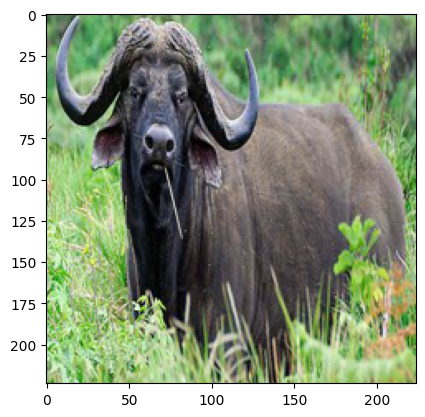

In [165]:
first = data.iloc[0]["numpy"]
print(first)

image = Image.fromarray(first, "RGB")

plt.imshow(image)

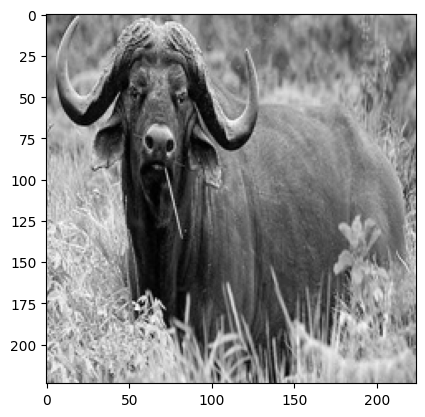

In [166]:
def gray_scale(image):
    return image.convert("L")


gray_image = gray_scale(image)
plt.imshow(gray_image, cmap="gray")
gray_image = np.asarray(gray_image)

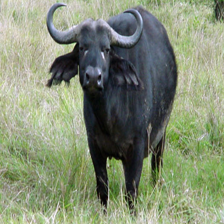

In [167]:
num = data.iloc[1]["numpy"]
image = Image.fromarray(num, "RGB")
image

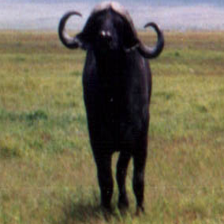

In [168]:
num = data.iloc[76]["numpy"]
image = Image.fromarray(num, "RGB")
image

In [169]:
s = []

for i in range(len(data)):
    num = data.iloc[i]["numpy"]
    image = Image.fromarray(num, "RGB")
    s.append(np.asarray(gray_scale(image)))

data["gray"] = s

In [170]:
data.columns

Index(['x_center', 'y_center', 'width', 'height', 'image', 'animal', 'numpy',
       'gray'],
      dtype='object')

In [171]:
data.head()

,x_center,y_center,width,height,image,animal,numpy,gray
0,0.560000,0.663017,0.644769,0.644769,001.jpg,0,"[[[67, 108, 76], [76, 114, 74], [83, 120, 79],...","[[92, 98, 104, 115, 124, 126, 119, 115, 119, 1..."
1,0.473515,0.508434,0.838554,0.838554,002.jpg,0,"[[[178, 179, 160], [204, 205, 194], [208, 209,...","[[177, 203, 208, 209, 209, 212, 205, 201, 211,..."
2,0.819167,0.593750,0.242500,0.242500,003.jpg,0,"[[[104, 77, 68], [94, 67, 58], [87, 60, 51], [...","[[84, 74, 67, 88, 97, 93, 78, 69, 65, 60, 52, ..."
3,0.386719,0.612225,0.653295,0.653295,004.jpg,0,"[[[227, 174, 126], [223, 171, 128], [220, 170,...","[[184, 182, 180, 172, 174, 169, 173, 181, 180,..."
4,0.238000,0.568513,0.244898,0.244898,005.jpg,0,"[[[135, 139, 138], [131, 135, 134], [124, 128,...","[[138, 134, 127, 122, 117, 117, 116, 108, 104,..."


In [172]:
print(type(data.iloc[0]["numpy"]))

<class 'numpy.ndarray'>


In [173]:
X_train, X_test, y_train, y_test = train_test_split(
    data["gray"].to_numpy(), data["animal"].to_numpy(), test_size=0.2, random_state=42
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    data["numpy"].to_numpy(), data["animal"].to_numpy(), test_size=0.2, random_state=42
)

In [174]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Num GPUs Available:  0
cuda


In [ ]:
# Stack the arrays into a single numpy array
# X_train is currently an array of arrays (object dtype)
# We need to stack them into shape (N, H, W) or (N, C, H, W)
X_train_stacked = np.stack(X_train)  # Shape: (num_samples, 224, 224)
X_test_stacked = np.stack(X_test)

X_train_reg_stacked = np.stack(X_train_reg)
X_test_reg_stacked = np.stack(X_test_reg)


# Convert to tensors and add channel dimension
# For grayscale images with ResNet (expects 3 channels), we need shape (N, C, H, W)
X_train_tensor = (
    torch.from_numpy(X_train_stacked).float().unsqueeze(1)
)  # Add channel dim
X_test_tensor = torch.from_numpy(X_test_stacked).float().unsqueeze(1)

X_train_reg_tensor = (
    torch.from_numpy(X_train_reg_stacked).float().unsqueeze(1)
)  # Add channel dim
X_test_reg_tensor = torch.from_numpy(X_test_reg_stacked).float().unsqueeze(1)

# Repeat grayscale to 3 channels for ResNet (or modify ResNet's first layer)
X_train_tensor = X_train_tensor.repeat(1, 3, 1, 1)  # (N, 3, 224, 224)
X_test_tensor = X_test_tensor.repeat(1, 3, 1, 1)


Y_train_tensor = torch.from_numpy(y_train).long()
Y_test_tensor = torch.from_numpy(y_test).long()

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"Y_train_tensor shape: {Y_train_tensor.shape}")
print(f"Y_test_tensor shape: {Y_test_tensor.shape}")
print(f"X_train_reg_tensor shape: {X_train_reg_tensor.shape}")
print(f"X_test_reg_tensor shape: {X_test_reg_tensor.shape}")
# print(f"Y_train_reg_tensor shape: {Y_train_reg_tensor.shape}")
# print(f"Y_test_reg_tensor shape: {Y_test_reg_tensor.shape}")

X_train_tensor shape: torch.Size([1203, 3, 224, 224])
X_test_tensor shape: torch.Size([301, 3, 224, 224])
Y_train_tensor shape: torch.Size([1203])
Y_test_tensor shape: torch.Size([301])
X_train_reg_tensor shape: torch.Size([1203, 1, 224, 224, 3])
X_test_reg_tensor shape: torch.Size([301, 1, 224, 224, 3])


In [176]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def trainModel(
    dataloader, model, loss_fn, optimizer, current_epoch: int, total_epochs: int
):
    model.train()
    total_loss = 0.0
    size = len(dataloader.dataset)
    # build a proper description string
    desc = f"EPOCH [TRAIN] {current_epoch+1}/{total_epochs}"
    tk = tqdm(dataloader, desc=desc)
    for batch_idx, (X, y) in enumerate(tk):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        # accumulate and display running average loss
        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1)
        tk.set_postfix(loss=f"{avg_loss:.4f}")
    # return the average loss if you like
    return total_loss / len(dataloader)


def testModel(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    size = len(dataloader.dataset)
    current_epoch = 0
    total_epochs = 1
    desc = f"EPOCH [TEST]  {current_epoch+1}/{total_epochs}"
    tk = tqdm(dataloader, desc=desc)
    for batch_idx, (X, y) in enumerate(tk):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        total_loss += loss.item()
        correct += (logits.argmax(dim=1) == y).sum().item()
        # update pogress bar
        avg_loss = total_loss / (batch_idx + 1)
        batch_acc = correct / ((batch_idx + 1) * dataloader.batch_size)
        tk.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{100*batch_acc:.1f}%")
    # final metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / size
    print(
        f"\nTest Error:\n  Accuracy: {100*accuracy:>5.1f}%, Avg loss: {avg_loss:>8.4f}\n"
    )
    return 100 * accuracy

In [ ]:
dataset = TensorDataset(X_train_tensor, Y_train_tensor)

modelPytorch = ResNet18(num_classes=4).to(device)

momentum = 0.9
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelPytorch.parameters(), lr=1e-5)

train_dataloader_Latest = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader_Latest = DataLoader(dataset, batch_size=32, shuffle=False)

epochs = 5

for t in range(epochs):
    trainModel(train_dataloader_Latest, modelPytorch, loss_fn, optimizer, t, epochs)
accuracy = testModel(test_dataloader_Latest, modelPytorch, loss_fn)
print("Done!")

PATH = "animalPytorch.pth"
torch.save(modelPytorch.state_dict(), PATH)

EPOCH [TEST]  1/1: 100%|██████████| 38/38 [00:04<00:00,  9.25it/s, acc=74.4%, loss=0.5949]


Test Error:
  Accuracy:  75.2%, Avg loss:   0.5949

Done!


In [ ]:
img_height = 224
img_width = 224
num_classes = 4

model = Sequential(
    [
        layers.Conv2D(
            16,
            3,
            padding="same",
            activation="relu",
            input_shape=(img_height, img_width, 1),
        ),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes),
    ]
)

tf_input = tf.keras.layers.Input(shape=(img_height, img_width, 3), batch_size=32)

model2 = tf.keras.applications.ResNet101(
    include_top=False,
    input_tensor=tf_input,
    input_shape=(img_height, img_width, 3),
    pooling=1,
    classes=num_classes,
    classifier_activation="softmax",
)


model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 28, 28, 64)     

In [185]:
# Add channel dimension for grayscale images (N, H, W) -> (N, H, W, 1)
X_train_with_channels = np.expand_dims(X_train_stacked, axis=-1)
X_test_with_channels = np.expand_dims(X_test_stacked, axis=-1)

tensorflow_x_train = tf.convert_to_tensor(X_train_with_channels, dtype=tf.float32)
tensorflow_x_test = tf.convert_to_tensor(X_test_with_channels, dtype=tf.float32)
tensorflow_y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
tensorflow_y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

print(f"X_train shape: {tensorflow_x_train.shape}")
print(f"X_test shape: {tensorflow_x_test.shape}")
print(f"y_train shape: {tensorflow_y_train.shape}")
print(f"y_test shape: {tensorflow_y_test.shape}")

X_train shape: (1203, 224, 224, 1)
X_test shape: (301, 224, 224, 1)
y_train shape: (1203,)
y_test shape: (301,)


In [202]:
epochs = 5

history = model.fit(
    tensorflow_x_train,
    tensorflow_y_train,
    validation_data=(tensorflow_x_test, tensorflow_y_test),
    epochs=epochs,
)

Epoch 1/5
38/38 [==============================] - 25s 667ms/step - loss: 1.1411 - accuracy: 0.4946 - val_loss: 0.8715 - val_accuracy: 0.6811
Epoch 2/5
38/38 [==============================] - 28s 730ms/step - loss: 0.5394 - accuracy: 0.8146 - val_loss: 0.8447 - val_accuracy: 0.6711
Epoch 3/5
38/38 [==============================] - 25s 648ms/step - loss: 0.2161 - accuracy: 0.9318 - val_loss: 1.0888 - val_accuracy: 0.7442
Epoch 4/5
38/38 [==============================] - 25s 650ms/step - loss: 0.1279 - accuracy: 0.9618 - val_loss: 1.4146 - val_accuracy: 0.6844
Epoch 5/5
38/38 [==============================] - 24s 643ms/step - loss: 0.0880 - accuracy: 0.9742 - val_loss: 1.3356 - val_accuracy: 0.7243


In [199]:
model.save("model.keras")

NameError: name 'YOLO' is not defined